In [1]:
pip install --upgrade tensorflow tensorflow-io

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [3]:
cd drive/MyDrive/colab_dl/capuchin

/content/drive/MyDrive/colab_dl/capuchin


In [4]:
ls

data/


In [5]:
CAPUCHIN_FILE = os.path.join('data','Parsed_Capuchinbird_Clips','XC114131-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data','Parsed_Not_Capuchinbird_Clips','afternoon-birds-song-in-forest-18.wav')

In [6]:
CAPUCHIN_FILE, NOT_CAPUCHIN_FILE

('data/Parsed_Capuchinbird_Clips/XC114131-3.wav',
 'data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-18.wav')

In [7]:
def load_wav_16k_mono(filename):
  file_contents = tf.io.read_file(filename) # Load encoded wav file
  wav, sr = tf.audio.decode_wav(file_contents, desired_channels=1) # Decode wav (tensors by channels)
  wav = tf.squeeze(wav, axis=-1) # Remove trailing axis
  sr = tf.cast(sr, dtype=tf.int64)
  wav = tfio.audio.resample(wav, rate_in=sr, rate_out=16000) # Goes from 44100Hz to 16000Hz -> amplitude of the audio signal
  return wav

In [8]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

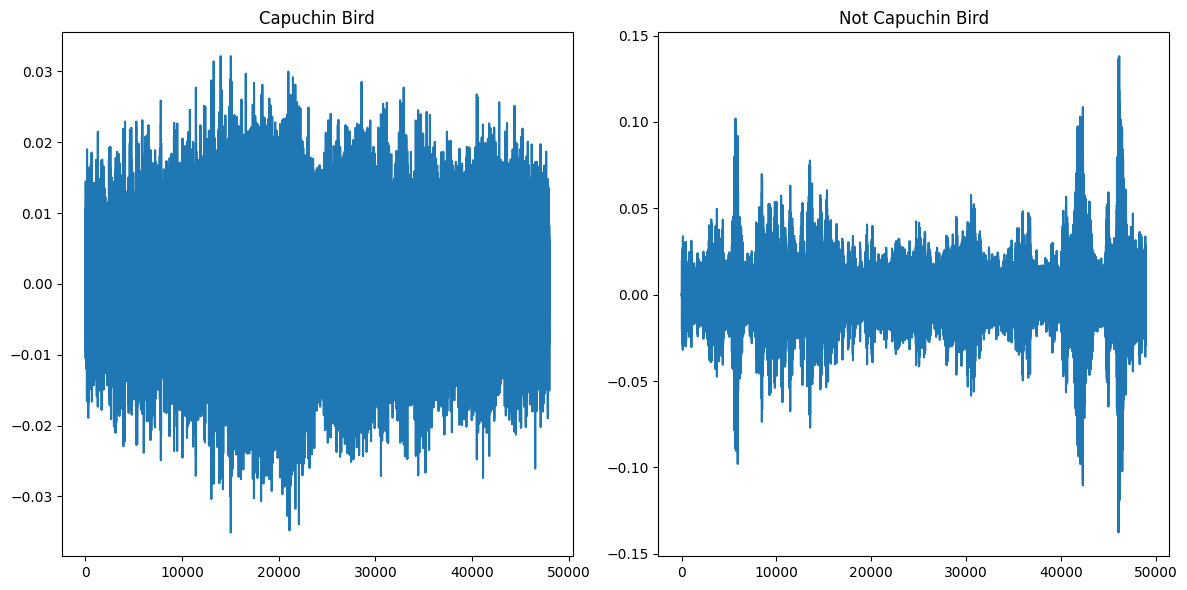

In [9]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(wave)
plt.title('Capuchin Bird')


plt.subplot(1, 2, 2)
plt.plot(nwave)
plt.title('Not Capuchin Bird')

plt.tight_layout()

plt.show()

In [10]:
POS = os.path.join('data','Parsed_Capuchinbird_Clips')
NEG = os.path.join('data','Parsed_Not_Capuchinbird_Clips')

In [11]:
POS, NEG

('data/Parsed_Capuchinbird_Clips', 'data/Parsed_Not_Capuchinbird_Clips')

In [12]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [13]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [14]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
  tensor_wave = load_wav_16k_mono(os.path.join('data','Parsed_Capuchinbird_Clips',file))
  lengths.append(len(tensor_wave))

In [15]:
# print(lengths)

In [16]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [17]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [18]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [19]:
def preprocess(file_path, label):
  wav = load_wav_16k_mono(file_path)
  wav = wav[:48000]
  zero_padding = tf.zeros([48000]-tf.shape(wav), dtype=tf.float32)
  wav = tf.concat([zero_padding, wav], 0)
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram, label

In [20]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [21]:
spectrogram, label = preprocess(filepath, label)

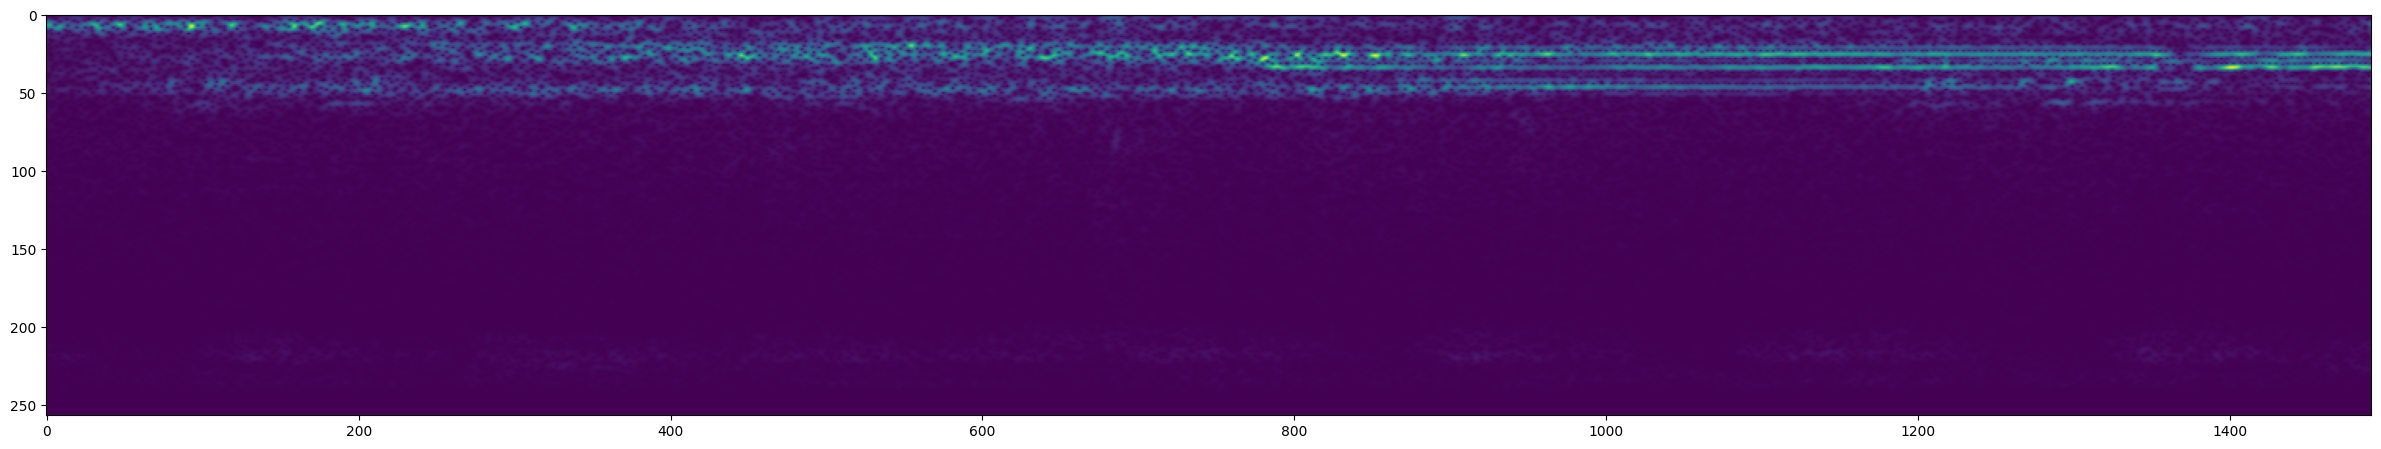

In [22]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

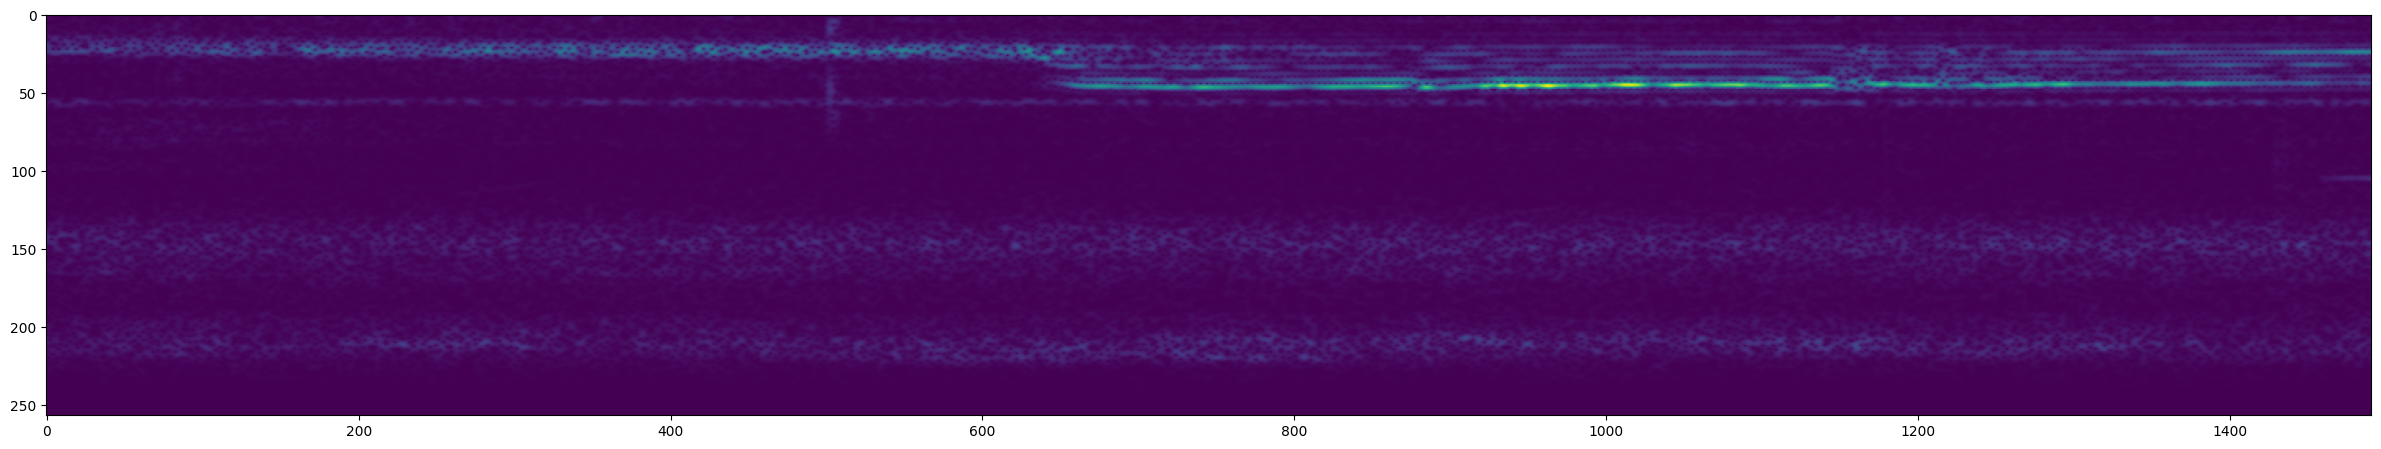

In [23]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [24]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [26]:
len(data)*.7

19.599999999999998

In [27]:
train = data.take(20)
test = data.skip(20).take(8)

In [28]:
samples, labels = train.as_numpy_iterator().next()

In [30]:
samples.shape, labels.shape

((16, 1491, 257, 1), (16,))

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D

In [68]:
# model = Sequential([
#     Conv2D(16, (3,3), activation='relu', input_shape=(1491,257,1)),
#     Conv2D(16, (3,3), activation='relu'),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491,257,1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [69]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=['accuracy'])

In [70]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 744, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 371, 62, 16)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 368032)            0         
                                                                 
 dense_12 (Dense)            (None, 128)              

In [71]:
hist = model.fit(train, epochs=100, validation_data=test)

Epoch 1/100
20/20 [==============================] - 3s 92ms/step - loss: 1.9451 - accuracy: 0.5031 - val_loss: 0.7147 - val_accuracy: 0.4474
Epoch 2/100
20/20 [==============================] - 2s 87ms/step - loss: 0.7107 - accuracy: 0.4625 - val_loss: 0.6891 - val_accuracy: 0.5439
Epoch 3/100
20/20 [==============================] - 2s 84ms/step - loss: 0.6943 - accuracy: 0.5000 - val_loss: 0.6990 - val_accuracy: 0.4737
Epoch 4/100
20/20 [==============================] - 2s 87ms/step - loss: 0.6954 - accuracy: 0.4750 - val_loss: 0.6870 - val_accuracy: 0.5439
Epoch 5/100
20/20 [==============================] - 2s 110ms/step - loss: 0.6976 - accuracy: 0.4688 - val_loss: 0.6962 - val_accuracy: 0.5526
Epoch 6/100
20/20 [==============================] - 2s 117ms/step - loss: 0.6937 - accuracy: 0.4656 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 7/100
20/20 [==============================] - 2s 112ms/step - loss: 0.6942 - accuracy: 0.4812 - val_loss: 0.6941 - val_accuracy: 0.4386
Epo

In [72]:
hist.history

{'loss': [1.9450781345367432,
  0.7106924653053284,
  0.6942898035049438,
  0.6954004764556885,
  0.6975620985031128,
  0.6937322616577148,
  0.6941961050033569,
  0.6945546865463257,
  0.6937482953071594,
  0.693605899810791,
  0.6931943893432617,
  0.6929744482040405,
  0.6932568550109863,
  0.6932661533355713,
  0.6938439607620239,
  0.693273663520813,
  0.6934008002281189,
  0.6930888295173645,
  0.6933024525642395,
  0.6933833360671997,
  0.6933260560035706,
  0.693268358707428,
  0.693109929561615,
  0.6933456659317017,
  0.6932169795036316,
  0.6930959820747375,
  0.6932170391082764,
  0.6931818127632141,
  0.6931360960006714,
  0.6932330131530762,
  0.6933516263961792,
  0.6930567622184753,
  0.6935016512870789,
  0.6932326555252075,
  0.6931688189506531,
  0.6932518482208252,
  0.6930863261222839,
  0.6931665539741516,
  0.6931416392326355,
  0.6932054758071899,
  0.6932097673416138,
  0.6930902004241943,
  0.6930977702140808,
  0.6929541826248169,
  0.6931167840957642,
  0.69

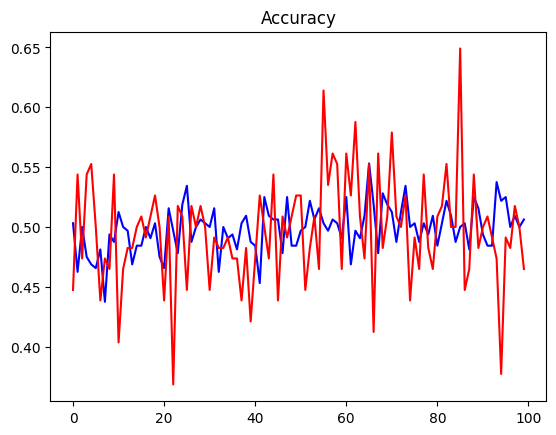

In [73]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'],'b')
plt.plot(hist.history['val_accuracy'],'r')
plt.show()

In [74]:
X_test, y_test = test.as_numpy_iterator().next()

In [75]:
y_test.shape

(16,)

In [86]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 33ms/step


In [87]:
yhat

array([[0.49477953],
       [0.49477953],
       [0.49477953],
       [0.49476576],
       [0.49477866],
       [0.49477953],
       [0.49477953],
       [0.49481893],
       [0.49477953],
       [0.49477953],
       [0.49477953],
       [0.49477953],
       [0.49477363],
       [0.49477953],
       [0.49477953],
       [0.49481252]], dtype=float32)

In [88]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [89]:
yhat

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [90]:
y_test

array([1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1.],
      dtype=float32)

In [91]:
tf.math.reduce_sum(yhat), tf.math.reduce_sum(y_test)

(<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [ ]:
# Verdict? -> I made a terrible model